In [86]:
import matplotlib.pyplot as plt
import pandas  as pd
import numpy   as np
import xgboost as xgb

In [87]:
dg_df = pd.read_csv('./big-ideas-lab-glycemic-variability-and-wearable-device-data-1.1.2/Demographics.csv')
dg_df.head(16)

,ID,Gender,HbA1c
0,13,MALE,5.7
1,1,FEMALE,5.5
2,3,FEMALE,5.9
3,4,FEMALE,6.4
4,5,FEMALE,5.7
5,2,MALE,5.6
6,6,FEMALE,5.8
7,7,FEMALE,5.3
8,8,FEMALE,5.6
9,10,FEMALE,6.0


In [88]:
df = pd.read_csv(r'./normalized_features.csv', sep='\t', encoding='utf-8')

In [89]:
df = df.dropna().drop(columns=['Unnamed: 0']).reset_index(drop=True)

In [90]:
df.isna().sum()

calories2hr       0
protein2hr        0
sugar2hr          0
carbs2hr          0
calories8hr       0
                 ..
datetime          0
ID                0
HbA1c             0
Biological Sex    0
label             0
Length: 83, dtype: int64

In [91]:
df['Biological Sex'] = df['Biological Sex'].map({'FEMALE': 0, 'MALE': 1})

In [92]:
df['label'] = df['label'].map({'PersLow': 0, 'PersNorm': 1, 'PersHigh':2})

In [93]:
corrdf = df.drop(columns=['datetime']).corr()

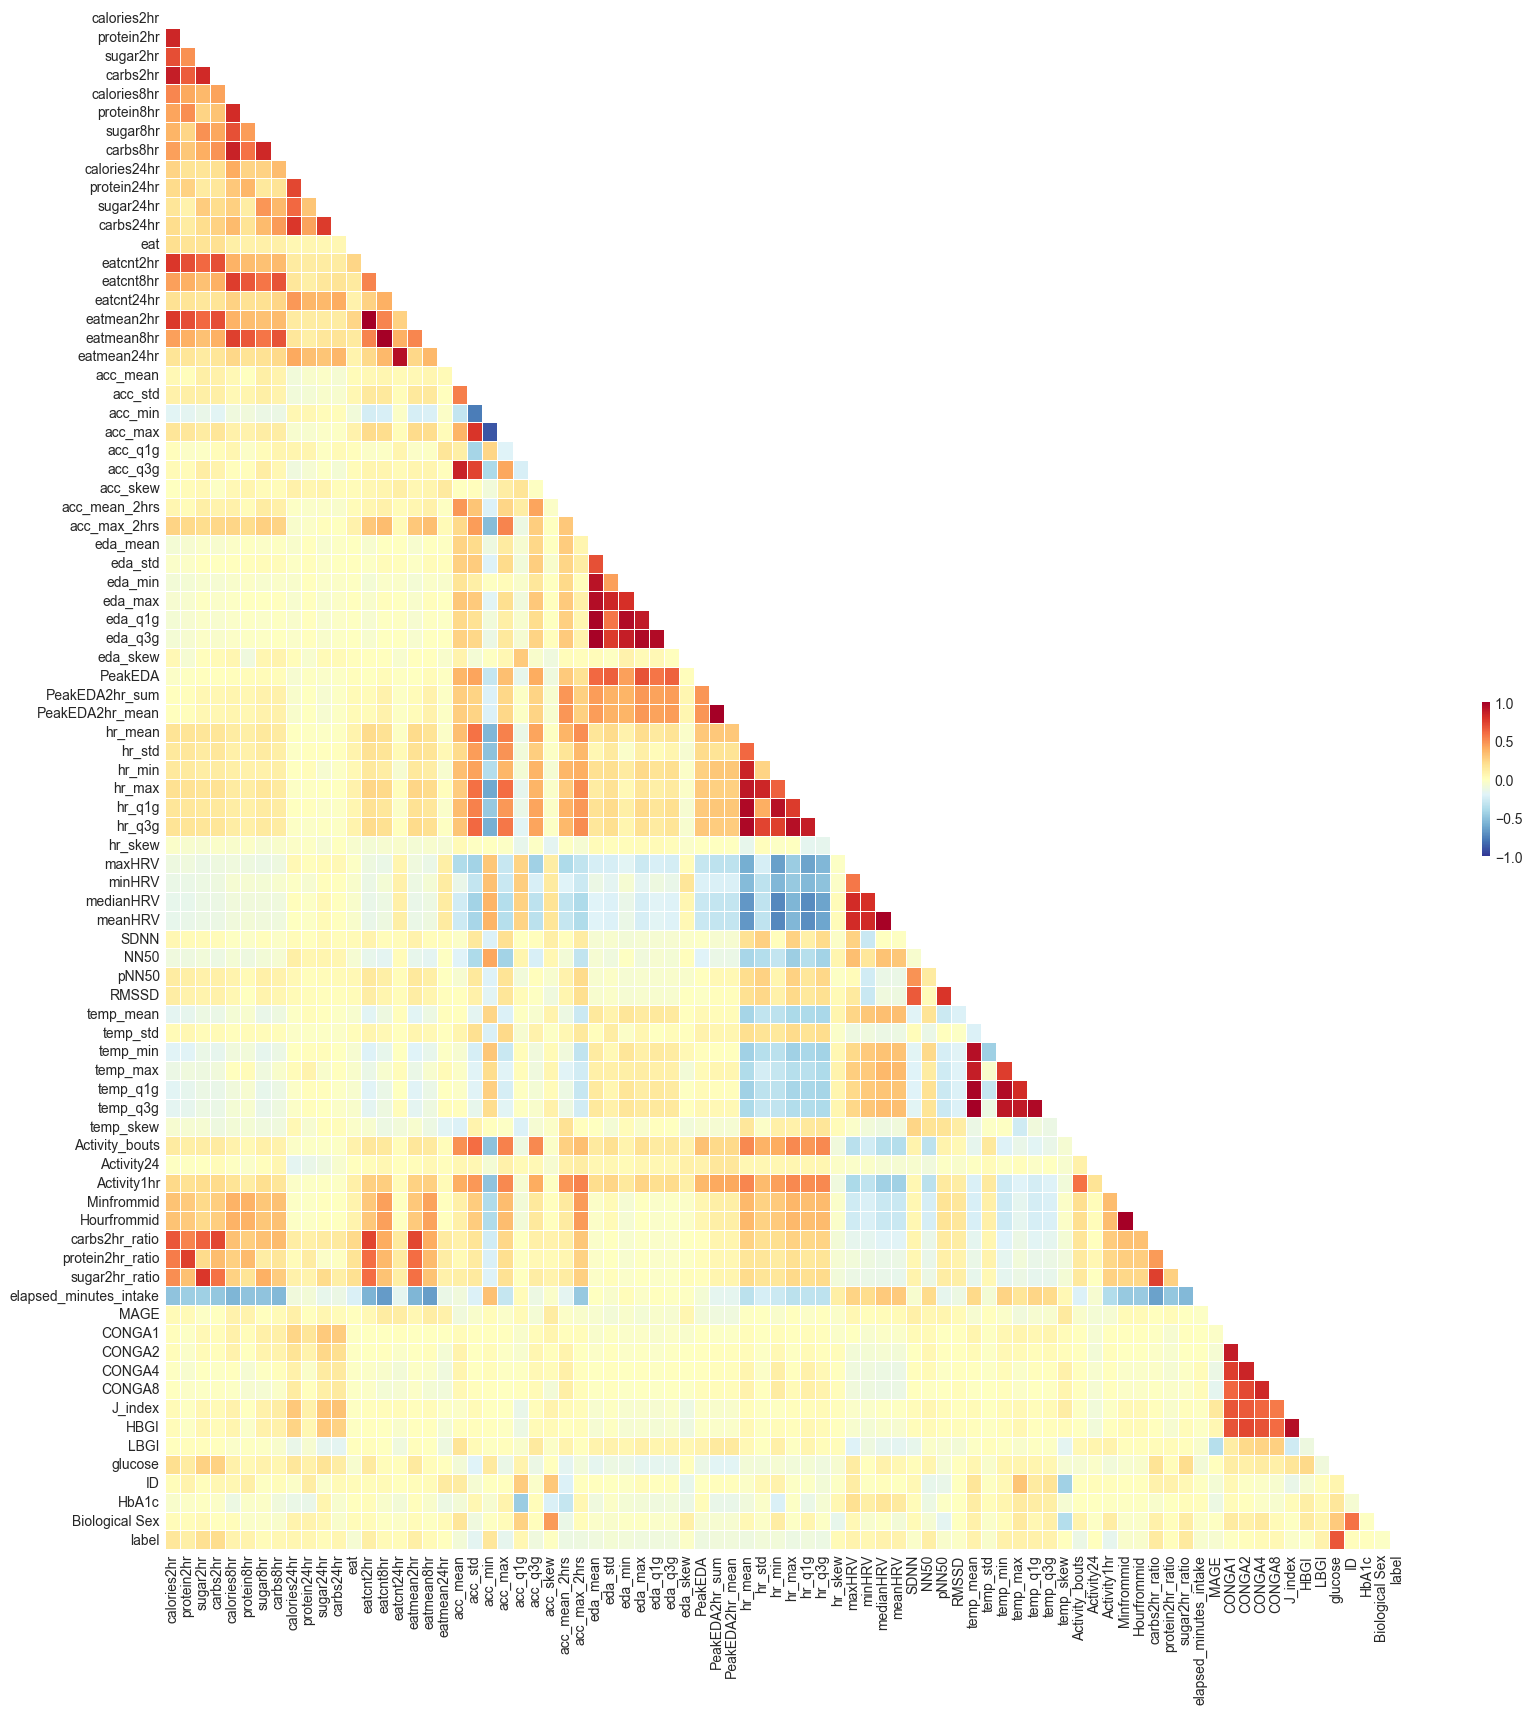

In [94]:
import seaborn as sns

# 그림 사이즈 지정
fig, ax = plt.subplots( figsize=(20,20) )

mask = np.zeros_like(corrdf)
mask[np.triu_indices_from(mask)] = True

# 히트맵을 그린다
sns.heatmap(corrdf, 
            cmap = 'RdYlBu_r', 
            annot = False,   # 실제 값을 표시한다
            mask=mask,      # 표시하지 않을 마스크 부분을 지정한다
            linewidths=.5,  # 경계면 실선으로 구분하기
            cbar_kws={"shrink": .1},# 컬러바 크기 줄이기
            vmin = -1,vmax = 1   # 컬러바 범위 -1 ~ 1
           )  
plt.show()

## 1. 독립적 교차 검증(subject-independent cross-validation), LOSO(Leave-One-Subject-Out) Model

In [95]:
def XGBLOSO(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000):
    """
        Intermediate function. 
    """
    # Get important features
    #listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators)
    #filteredi = listimportances[listimportances['importances'] < fs]
    #filteredi = filteredi['value']
    
    LOOCV_O = int(float(ids))
    data.loc[:,idcolumn] = data.loc[:,idcolumn].apply(int)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')
    
    # Test data - the person left out of training
    data_test = data_cv.drop(columns=dropcols)
    #data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable

    #X_test.loc[:, idcolumn] = X_test.loc[:, idcolumn].astype(pd.to_numeric)
    
    # Train data - all other people in dataframe
    data_train = data_filtered.drop(columns=dropcols)
    #data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])

    feature_list = list(X_train.columns)
    #X_train= X_train
    y_train = data_train[outcomevar]

    #X_train.loc[:, idcolumn] = X_train.loc[:, idcolumn].astype(pd.to_numeric)


    # XGBoost Regressor with fixed parameters
    xgbr = xgb.XGBRegressor(
        n_estimators=numestimators,
        max_depth=6,
        learning_rate=0.1,
        random_state=0,
        enable_categorical=True
    )
    print('Now processing... XGBoost - Leave One Subject Out')
    xgbr.fit(X_train, y_train)
    
    test_predictions = xgbr.predict(X_test)
    train_predictions = xgbr.predict(X_train)
    errors = abs(test_predictions - y_test)

    # Root Mean Squared Error (RMSE)
    from sklearn import metrics
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, test_predictions))
    test_rmse = RMSE
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_predictions))
    train_r2 = metrics.r2_score(y_train, train_predictions)
    test_r2 = metrics.r2_score(y_test, test_predictions)
    
    # Mean Average Percent Error (MAPE)
    MAPerror = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100 
    test_mape = MAPerror
    train_mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100 
    
    # List of tuples with variable and importance
    importances = list(xgbr.feature_importances_)
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    important['id'] = str(ids)
    
    return train_rmse, test_rmse, train_mape, test_mape, train_r2, test_r2, errors, RMSE, MAPerror, test_r2, important

def losoXGB(data, idcolumn, outcomevar, dropcols=[], numestimators=1000):
    """
        Main LOSO XGB function that calls other functions to do XGB training, and testing. 

        Args:
          
        Returns:
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(data[idcolumn].astype(str).unique())
    print(f'IDlist : {IDlist}')
    drop = [] #drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    r2_list = []
    importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    rmse_df = pd.DataFrame(columns=['train_rmse','test_rmse', 'id'])
    mape_df = pd.DataFrame(columns=['train_mape','test_mape', 'id'])
    acc_df = pd.DataFrame(columns=['train_acc','test_acc', 'id'])
    r2_df = pd.DataFrame(columns=['train_r2','test_r2', 'id'])
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        train_rmse, test_rmse, train_mape, test_mape, train_r2, test_r2, er, rm, ma, r2, imp= XGBLOSO(data, i, outcomevar, drop, idcolumn, numestimators)
        rmse_row = pd.DataFrame({'train_rmse': [train_rmse], 'test_rmse': [test_rmse], 'id': [str(i)]})
        rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
        mape_row = pd.DataFrame({'train_mape': [train_mape], 'test_mape': [test_mape], 'id': [str(i)]})
        mape_df = pd.concat([mape_df, mape_row], ignore_index=True)
        acc_row = pd.DataFrame({'train_acc': [100 - train_mape], 'test_acc': [100 - test_mape], 'id': [str(i)]})
        acc_df = pd.concat([acc_df, acc_row], ignore_index=True)
        r2_row = pd.DataFrame({'train_r2': [train_r2], 'test_r2': [test_r2], 'id': [str(i)]})
        r2_df = pd.concat([r2_df, r2_row], ignore_index=True)
        errors.append(er)
        rmse.append(rm)
        mape.append(ma)
        r2_list.append(r2)
        #eval = pd.DataFrame({'rmse': [rm], 'mape': [ma], 'id': [str(i)]})
        #eval_metrics = pd.concat([eval_metrics, eval], ignore_index=True)
        importances = pd.concat([importances, imp], ignore_index=True)
        idt = str(i)
        print('...' + idt + ' processing complete.')

    # Compute mean and std RMSE, MAPE
    meanrmse = np.mean(rmse)
    stdrmse = np.std(rmse)
    meanmape = np.mean(mape)
    stdmape = np.std(mape)
    meanr2 = np.mean(r2_list)
    stdr2 = np.std(r2_list)
    
    # Print RMSE, MAPE
    print('Mean RMSE:' + str(meanrmse))
    print('Std RMSE:' + str(stdrmse))
    print('Mean MAPE:' + str(meanmape))
    print('Std MAPE:' + str(stdmape))
    #print('Mean R2:' + str(meanr2))
    #print('Std R2:' + str(stdr2))
    
    eval_df = rmse_df.merge(mape_df, on='id').merge(acc_df, on='id')#.merge(r2_df, on='id')
    
    #TODO: 파라미터들을 담은 dataframe을 반환하도록 할 것.
    return eval_df, errors, meanrmse, stdrmse, meanmape, stdmape, importances

In [96]:
eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = losoXGB(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime','carbs2hr_ratio','protein2hr_ratio','sugar2hr_ratio'], numestimators=100)

IDlist : ['1.0', '2.0', '3.0', '4.0', '5.0', '6.0', '7.0', '8.0', '9.0', '10.0', '11.0', '12.0', '13.0', '14.0', '16.0']
LOOCV_O : 1
Now processing... XGBoost - Leave One Subject Out
...1.0 processing complete.
LOOCV_O : 2
Now processing... XGBoost - Leave One Subject Out
...2.0 processing complete.
LOOCV_O : 3
Now processing... XGBoost - Leave One Subject Out
...3.0 processing complete.
LOOCV_O : 4
Now processing... XGBoost - Leave One Subject Out
...4.0 processing complete.
LOOCV_O : 5
Now processing... XGBoost - Leave One Subject Out
...5.0 processing complete.
LOOCV_O : 6
Now processing... XGBoost - Leave One Subject Out
...6.0 processing complete.
LOOCV_O : 7
Now processing... XGBoost - Leave One Subject Out
...7.0 processing complete.
LOOCV_O : 8
Now processing... XGBoost - Leave One Subject Out
...8.0 processing complete.
LOOCV_O : 9
Now processing... XGBoost - Leave One Subject Out
...9.0 processing complete.
LOOCV_O : 10
Now processing... XGBoost - Leave One Subject Out
...10.

In [97]:
eval_df.head(20)

,train_rmse,test_rmse,id,train_mape,test_mape,train_acc,test_acc
0,7.489498,16.370592,1.0,4.767069,13.024615,95.232931,86.975385
1,7.313697,23.900211,2.0,4.669924,15.131804,95.330076,84.868196
2,7.562130,19.348781,3.0,4.803476,11.643925,95.196524,88.356075
3,7.402388,18.856863,4.0,4.695038,13.108355,95.304962,86.891645
4,7.567241,12.690600,5.0,4.757031,10.438934,95.242969,89.561066
5,7.338804,23.945683,6.0,4.695289,11.810672,95.304711,88.189328
6,7.532951,25.994806,7.0,4.749436,25.938513,95.250564,74.061487
7,7.439138,13.332221,8.0,4.714593,8.641471,95.285407,91.358529
8,7.451424,20.795291,9.0,4.772254,12.890474,95.227746,87.109526
9,7.047555,26.786713,10.0,4.546979,15.365456,95.453021,84.634544


In [98]:
# Compute average of RMSE
avg_train_rmse = eval_df['train_rmse'].mean()
avg_test_rmse = eval_df['test_rmse'].mean()
# Compute average of MAPE
avg_train_mape = eval_df['train_acc'].mean()
avg_test_mape = eval_df['test_acc'].mean()

In [99]:
imp_err = importances.groupby('value').std().rename(columns={'importances':'std'})

In [100]:
filteredimp = importances.groupby('value').mean().sort_values(by='importances', ascending=False)
filteredimp = pd.merge(filteredimp, imp_err, on='value')
print(filteredimp)

                 importances       std
value                                 
Biological Sex      0.205884  0.090702
HbA1c               0.061080  0.026495
PeakEDA2hr_mean     0.059836  0.037654
sugar2hr            0.049473  0.011130
eatmean2hr          0.031841  0.020069
...                      ...       ...
hr_std              0.001416  0.000643
acc_mean            0.001091  0.000324
temp_std            0.001052  0.000467
acc_max             0.000958  0.001024
hr_skew             0.000542  0.000220

[77 rows x 2 columns]


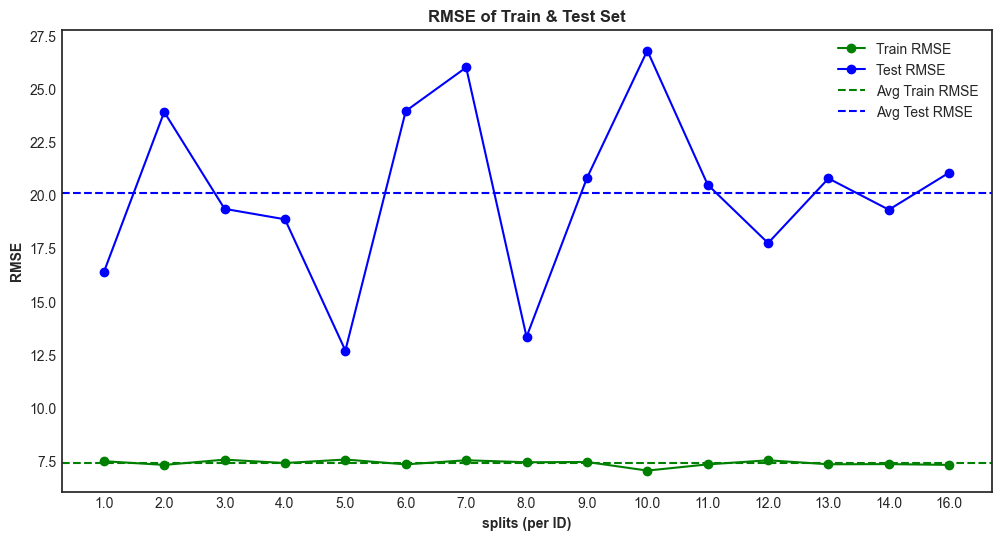

In [101]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(eval_df['id'], eval_df['train_rmse'], 'go-', label='Train RMSE')
plt.plot(eval_df['id'], eval_df['test_rmse'], 'bo-', label='Test RMSE')

# 가로 점선 추가 (평균값 표시)
plt.axhline(y=avg_train_rmse, color='g', linestyle='--', label='Avg Train RMSE')
plt.axhline(y=avg_test_rmse, color='b', linestyle='--', label='Avg Test RMSE')

# 레이블 및 제목 설정
plt.xlabel('splits (per ID)', fontweight='bold')
plt.ylabel('RMSE', fontweight='bold')
plt.title('RMSE of Train & Test Set', fontweight='bold')
plt.xticks(eval_df['id'])

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()


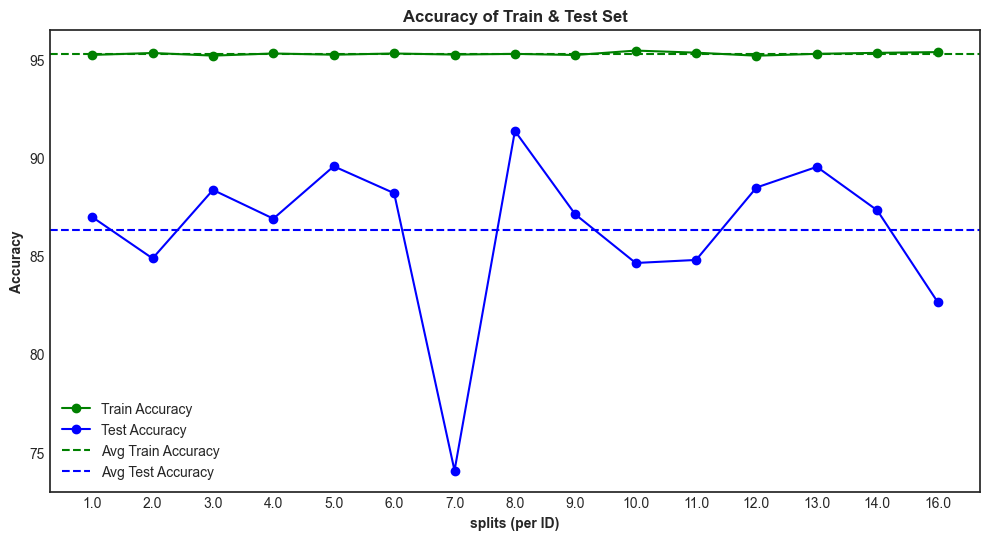

In [102]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(eval_df['id'], eval_df['train_acc'], 'go-', label='Train Accuracy')
plt.plot(eval_df['id'], eval_df['test_acc'], 'bo-', label='Test Accuracy')

# 가로 점선 추가 (평균값 표시)
plt.axhline(y=avg_train_mape, color='g', linestyle='--', label='Avg Train Accuracy')
plt.axhline(y=avg_test_mape, color='b', linestyle='--', label='Avg Test Accuracy')

# 레이블 및 제목 설정
plt.xlabel('splits (per ID)', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy of Train & Test Set', fontweight='bold')
plt.xticks(eval_df['id'])

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()

C:\Users\이경주\AppData\Local\Temp\ipykernel_14296\2107135607.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


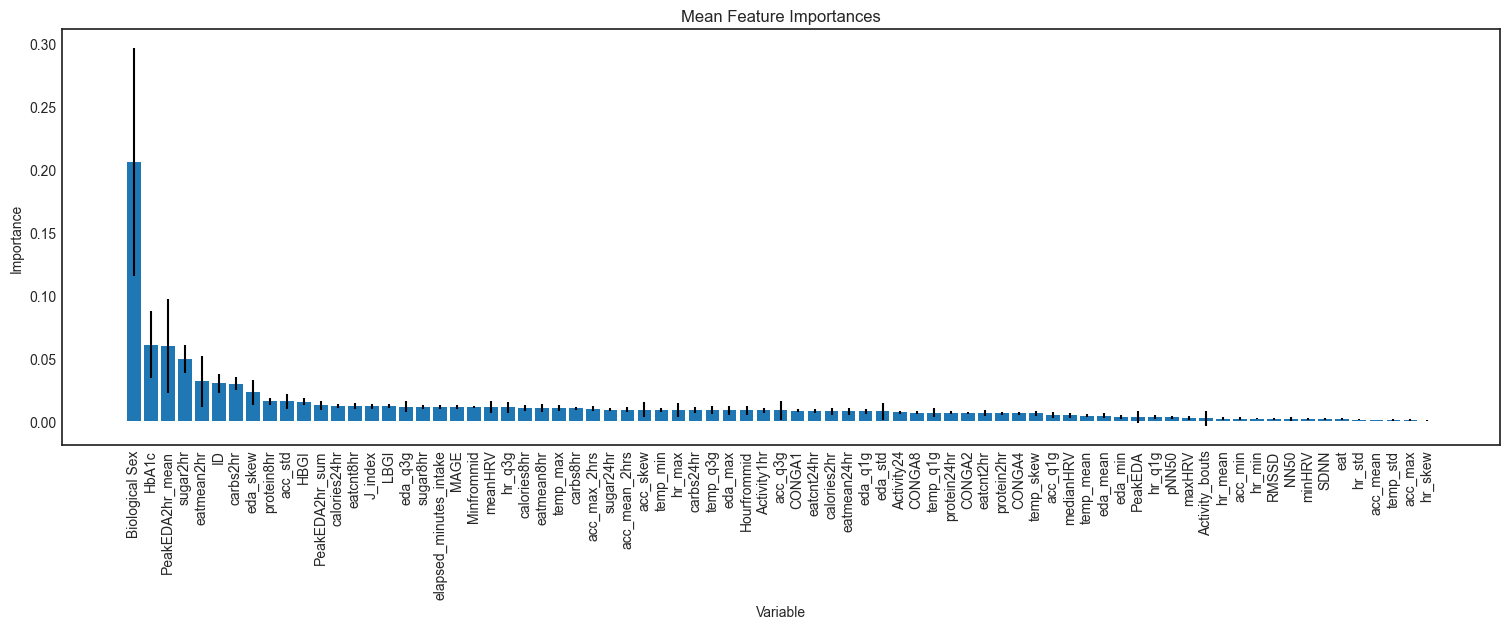

In [103]:
plt.style.use('seaborn-white')
plt.figure(figsize=(15, 6))
x_values = list(range(len(filteredimp['importances'])))
# Make a bar chart
plt.bar(x_values, filteredimp['importances'], orientation = 'vertical', yerr=filteredimp['std'])# Tick labels for x axis
plt.xticks(x_values, filteredimp.index, rotation='vertical')# Axis labels and title
plt.tight_layout()
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title(('Mean Feature Importances'))
plt.show()

## 3. 부분 개인화 교차 검증(partial personalization cross-validation) Model

In [104]:
def XGBPartialPersonalization(data, ids, outcomevar, dropcols, idcolumn, numestimators=1000, personalization_train_percent=0.5):
    """
        Intermediate function. 
    """
    # Get important features
    #listimportances = LOOCV_featureselection(data, ids, outcomevar, dropcols, idcolumn, numestimators)
    #filteredi = listimportances[listimportances['importances'] < fs]
    #filteredi = filteredi['value']
    
    LOOCV_O = int(float(ids))
    data.loc[:,idcolumn] = data.loc[:,idcolumn].apply(int)
    data_filtered = data[data[idcolumn] != LOOCV_O]
    data_cv = data[data[idcolumn] == LOOCV_O]

    print(f'LOOCV_O : {LOOCV_O}')

    train_cnt = int(len(data_cv) * personalization_train_percent)
    person_split_train = data_cv.iloc[:train_cnt]
    person_split_test = data_cv.iloc[train_cnt:]
    
    # Test data - the person left out of training
    data_test = person_split_test
    data_test = data_test.drop(columns=dropcols)
    #data_test = data_test.drop(columns=filteredi) #cvf
    X_test = data_test.drop(columns=[outcomevar])
    y_test = data_test[outcomevar] #This is the outcome variable

    #X_test.loc[:, idcolumn] = X_test.loc[:, idcolumn].astype(pd.to_numeric)
    
    # Train data - all other people in dataframe
    data_filtered = pd.concat([person_split_train, data_filtered], ignore_index=True)
    data_train = data_filtered.drop(columns=dropcols)
    #data_train = data_train.drop(columns=filteredi)
    X_train = data_train.drop(columns=[outcomevar])

    feature_list = list(X_train.columns)
    #X_train= X_train
    y_train = data_train[outcomevar]

    #X_train.loc[:, idcolumn] = X_train.loc[:, idcolumn].astype(pd.to_numeric)


    # XGBoost Regressor with fixed parameters
    xgbr = xgb.XGBRegressor(
        n_estimators=numestimators,
        max_depth=6,
        learning_rate=0.1,
        random_state=0,
        enable_categorical=True
    )
    print('Now processing... XGBoost - Leave One Subject Out')
    xgbr.fit(X_train, y_train)
    
    test_predictions = xgbr.predict(X_test)
    train_predictions = xgbr.predict(X_train)
    errors = abs(test_predictions - y_test)

    # Root Mean Squared Error (RMSE)
    from sklearn import metrics
    RMSE = np.sqrt(metrics.mean_squared_error(y_test, test_predictions))
    test_rmse = RMSE
    train_rmse = np.sqrt(metrics.mean_squared_error(y_train, train_predictions))
    
    # Mean Average Percent Error (MAPE)
    MAPerror = np.mean(np.abs((y_test - test_predictions) / y_test)) * 100 
    test_mape = MAPerror
    train_mape = np.mean(np.abs((y_train - train_predictions) / y_train)) * 100 
    
    train_r2 = metrics.r2_score(y_train, train_predictions)
    test_r2 = metrics.r2_score(y_test, test_predictions)
    
    # List of tuples with variable and importance
    importances = list(xgbr.feature_importances_)
    important = pd.DataFrame()
    important['value'] = feature_list
    important['importances'] = importances
    important['id'] = str(ids)
    
    return train_rmse, test_rmse, train_mape, test_mape, train_r2, test_r2, errors, RMSE, MAPerror, test_r2, important

def partialPersonalizationXGB(data, idcolumn, outcomevar, dropcols=[], numestimators=1000, personalization_train_percent = 0.5):
    """
        Main LOSO XGB function that calls other functions to do XGB training, and testing. 

        Args:
          
        Returns:
    """
    
    # Make list of all ID's in idcolumn
    IDlist = list(data[idcolumn].astype(str).unique())
    print(f'IDlist : {IDlist}')
    drop = [] #drop = [idcolumn]
    drop = drop + dropcols
    
    # Initialize empty lists and dataframe 
    errors = []
    rmse = []
    mape = []
    r2_list = []
    importances = pd.DataFrame(columns=['value', 'importances', 'id'])
    rmse_df = pd.DataFrame(columns=['train_rmse','test_rmse', 'id'])
    mape_df = pd.DataFrame(columns=['train_mape','test_mape', 'id'])
    acc_df = pd.DataFrame(columns=['train_acc','test_acc', 'id'])
    r2_df = pd.DataFrame(columns=['train_r2','test_r2', 'id'])
    
    # Run LOOCV Random Forest! 
    for i in IDlist:
        train_rmse, test_rmse, train_mape, test_mape, train_r2, test_r2, er, rm, ma, r2, imp= XGBPartialPersonalization(data, i, outcomevar, drop, idcolumn, numestimators, personalization_train_percent)
        rmse_row = pd.DataFrame({'train_rmse': [train_rmse], 'test_rmse': [test_rmse], 'id': [str(i)]})
        rmse_df = pd.concat([rmse_df, rmse_row], ignore_index=True)
        mape_row = pd.DataFrame({'train_mape': [train_mape], 'test_mape': [test_mape], 'id': [str(i)]})
        mape_df = pd.concat([mape_df, mape_row], ignore_index=True)
        acc_row = pd.DataFrame({'train_acc': [100 - train_mape], 'test_acc': [100 - test_mape], 'id': [str(i)]})
        acc_df = pd.concat([acc_df, acc_row], ignore_index=True)
        r2_row = pd.DataFrame({'train_r2': [train_r2], 'test_r2': [test_r2], 'id': [str(i)]})
        r2_df = pd.concat([r2_df, r2_row], ignore_index=True)
        errors.append(er)
        rmse.append(rm)
        mape.append(ma)
        r2_list.append(r2)
        #eval = pd.DataFrame({'rmse': [rm], 'mape': [ma], 'id': [str(i)]})
        #eval_metrics = pd.concat([eval_metrics, eval], ignore_index=True)
        importances = pd.concat([importances, imp], ignore_index=True)
        idt = str(i)
        print('...' + idt + ' processing complete.')

    # Compute mean and std RMSE, MAPE
    # Compute mean and std RMSE, MAPE
    meanrmse = np.mean(rmse)
    stdrmse = np.std(rmse)
    meanmape = np.mean(mape)
    stdmape = np.std(mape)
    meanr2 = np.mean(r2_list)
    stdr2 = np.std(r2_list)
    
    # Print RMSE, MAPE
    print('Mean RMSE:' + str(meanrmse))
    print('Std RMSE:' + str(stdrmse))
    print('Mean MAPE:' + str(meanmape))
    print('Std MAPE:' + str(stdmape))
    #print('Mean R2:' + str(meanr2))
    #print('Std R2:' + str(stdr2))
    
    eval_df = rmse_df.merge(mape_df, on='id').merge(acc_df, on='id')#.merge(r2_df, on='id')
    
    #TODO: 파라미터들을 담은 dataframe을 반환하도록 할 것.
    return eval_df, errors, meanrmse, stdrmse, meanmape, stdmape, importances

In [105]:
eval_df, errors, RMSE, RMSEstd, MAPE, MAPEstd, importances = partialPersonalizationXGB(data=df, idcolumn='ID', outcomevar='glucose', dropcols=['label', 'datetime','carbs2hr_ratio','protein2hr_ratio','sugar2hr_ratio'], numestimators=100)

IDlist : ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '16']
LOOCV_O : 1
Now processing... XGBoost - Leave One Subject Out
...1 processing complete.
LOOCV_O : 2
Now processing... XGBoost - Leave One Subject Out
...2 processing complete.
LOOCV_O : 3
Now processing... XGBoost - Leave One Subject Out
...3 processing complete.
LOOCV_O : 4
Now processing... XGBoost - Leave One Subject Out
...4 processing complete.
LOOCV_O : 5
Now processing... XGBoost - Leave One Subject Out
...5 processing complete.
LOOCV_O : 6
Now processing... XGBoost - Leave One Subject Out
...6 processing complete.
LOOCV_O : 7
Now processing... XGBoost - Leave One Subject Out
...7 processing complete.
LOOCV_O : 8
Now processing... XGBoost - Leave One Subject Out
...8 processing complete.
LOOCV_O : 9
Now processing... XGBoost - Leave One Subject Out
...9 processing complete.
LOOCV_O : 10
Now processing... XGBoost - Leave One Subject Out
...10 processing complete.
LOOCV_O : 11
Now processing

In [106]:
eval_df.head(20)

,train_rmse,test_rmse,id,train_mape,test_mape,train_acc,test_acc
0,7.535962,13.318358,1,4.785990,8.864442,95.214010,91.135558
1,7.247180,20.237169,2,4.640295,12.628324,95.359705,87.371676
2,7.659168,13.080137,3,4.853826,8.903847,95.146174,91.096153
3,7.571165,15.053042,4,4.783150,9.898014,95.216850,90.101986
4,7.644872,12.445259,5,4.827408,10.315020,95.172592,89.684980
5,7.408969,24.858815,6,4.728926,11.570022,95.271074,88.429978
6,7.552422,21.715903,7,4.773381,21.364076,95.226619,78.635924
7,7.354558,12.721957,8,4.690283,7.979806,95.309717,92.020194
8,7.592483,21.366710,9,4.833545,12.898258,95.166455,87.101742
9,7.390699,29.387960,10,4.712083,14.579081,95.287917,85.420919


In [107]:
# Compute average of RMSE
avg_train_rmse = eval_df['train_rmse'].mean()
avg_test_rmse = eval_df['test_rmse'].mean()
# Compute average of MAPE
avg_train_mape = eval_df['train_acc'].mean()
avg_test_mape = eval_df['test_acc'].mean()

In [108]:
imp_err = importances.groupby('value').std().rename(columns={'importances':'std'})

In [109]:
filteredimp = importances.groupby('value').mean().sort_values(by='importances', ascending=False)
filteredimp = pd.merge(filteredimp, imp_err, on='value')
print(filteredimp)

                 importances       std
value                                 
Biological Sex      0.209533  0.055777
PeakEDA2hr_mean     0.062313  0.023382
HbA1c               0.055780  0.015540
sugar2hr            0.047519  0.008597
carbs2hr            0.030643  0.005993
...                      ...       ...
hr_std              0.001133  0.000540
temp_std            0.001109  0.000434
Activity_bouts      0.001012  0.001064
acc_max             0.000912  0.000429
hr_skew             0.000516  0.000317

[77 rows x 2 columns]


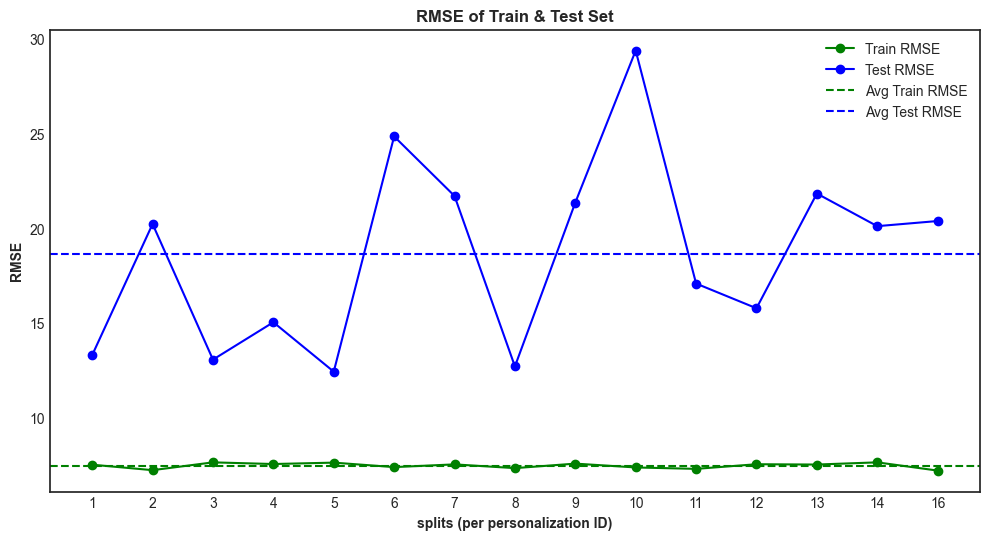

In [110]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(eval_df['id'], eval_df['train_rmse'], 'go-', label='Train RMSE')
plt.plot(eval_df['id'], eval_df['test_rmse'], 'bo-', label='Test RMSE')

# 가로 점선 추가 (평균값 표시)
plt.axhline(y=avg_train_rmse, color='g', linestyle='--', label='Avg Train RMSE')
plt.axhline(y=avg_test_rmse, color='b', linestyle='--', label='Avg Test RMSE')

# 레이블 및 제목 설정
plt.xlabel('splits (per personalization ID)', fontweight='bold')
plt.ylabel('RMSE', fontweight='bold')
plt.title('RMSE of Train & Test Set', fontweight='bold')
plt.xticks(eval_df['id'])

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()


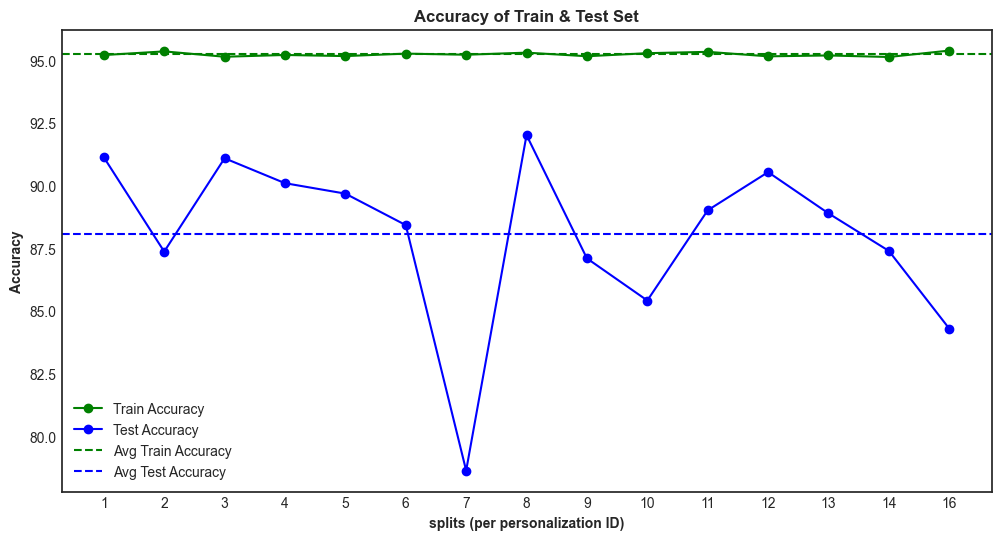

In [111]:
# 그래프 그리기
plt.figure(figsize=(12, 6))
plt.plot(eval_df['id'], eval_df['train_acc'], 'go-', label='Train Accuracy')
plt.plot(eval_df['id'], eval_df['test_acc'], 'bo-', label='Test Accuracy')

# 가로 점선 추가 (평균값 표시)
plt.axhline(y=avg_train_mape, color='g', linestyle='--', label='Avg Train Accuracy')
plt.axhline(y=avg_test_mape, color='b', linestyle='--', label='Avg Test Accuracy')

# 레이블 및 제목 설정
plt.xlabel('splits (per personalization ID)', fontweight='bold')
plt.ylabel('Accuracy', fontweight='bold')
plt.title('Accuracy of Train & Test Set', fontweight='bold')
plt.xticks(eval_df['id'])

# 범례 추가
plt.legend()

# 그래프 표시
plt.show()
